In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 120

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report


# make parent kaggle folder importable
import sys
import os
sys.path.append(os.path.abspath("../"))
import importlib
import utils as u
import graphs as g
import processing as p
import extraction as e
import selection as s
import model as m

Using TensorFlow backend.


# Data

In [68]:
train_data = pd.read_csv('input/train.csv')
train_data = train_data.fillna('')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [54]:
test_data = pd.read_csv('input/test.csv')
test_data = test_data.fillna('')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


# Sample extraction

In [54]:
import itertools

d = train_data[train_data.qid1==8461]
print(q.shape)

ids = list(itertools.combinations(d.qid2, 2))[0]
print(ids)

m = pd.concat([train_data, q], axis=0, ignore_index=True, verify_integrity=True, join='inner')
u.log('t', train_data.shape)
u.log('m', m.shape)

# u.log('cs', len(cs))

# train_data[['qid1']].groupby(['qid1']).size()

NameError: name 'q' is not defined

# Feature extraction

In [77]:
importlib.reload(p)

data = train_data.question1.append(train_data.question2)
text = data.append(test_data.question1).append(test_data.question2).values

question_we = p.word_encoder(text, title='corpus', stop_words=[], max_features=500)
question_features = question_we.get_feature_names()

# u.log('features', question_features)

corpus: 500 


In [78]:
importlib.reload(e)

x_q1 = e.extract(train_data, 'question1', question_we)
x_q2 = e.extract(train_data, 'question2', question_we)

# x_q1_test = e.extract(test_data, 'question1', question_we)
# x_q2_test = e.extract(test_data, 'question2', question_we)

E question1: (404290, 500) 
E question2: (404290, 500) 


In [94]:
# tf-idf score

def tfidf(row):
    tf1 = x_q1.iloc[row.id].sum()
    tf2 = x_q2.iloc[row.id].sum()
    return tf1 + tf2

train_data['tfidf'] = train_data.apply(tfidf, axis=1, raw=True)
# test_data['tfidf'] = x_q1_test.sum(axis=1) + x_q2_test.sum(axis=1)

/Users/syk/Work/kaggle/ENV/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [70]:
# question similarity 
from difflib import SequenceMatcher

def similar(row):
    return SequenceMatcher(None, row.question1, row.question2).ratio()

train_data['similar'] = train_data.apply(similar, axis=1, raw=True)
# test_data['similar'] = test_data.apply(similar, axis=1, raw=True)

In [75]:
# number of words

def count(row):
    w1 = len(row.question1.split())
    w2 = len(row.question2.split())
    return w1 + w2

train_data['words'] = train_data.apply(count, axis=1, raw=True)
# test_data['words'] = test_data.apply(count, axis=1, raw=True)

In [71]:
# shared words
from sklearn import feature_extraction as fe
stops = fe.text.ENGLISH_STOP_WORDS

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))   
    return len(w1 & w2)/(len(w1) + len(w2))

def shared_words(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words = [w for w in q1words.keys() if w in q2words]
    R = (len(shared_words))/(len(q1words) + len(q2words))
    return R

train_data['shared_words'] = train_data.apply(shared_words, axis=1, raw=True)
# test_data['shared_words'] = test_data.apply(shared_words, axis=1, raw=True)

In [73]:
# shared chars

def normalized_chars_share(row):
    c1 = set(list(row.question1))
    c2 = set(list(row.question2))
    return len(c1 & c2)/(len(c1) + len(c2))

train_data['shared_chars'] = train_data.apply(normalized_chars_share, axis=1, raw=True)

,id,qid1,qid2,is_duplicate,tfidf,similar,shared_words,shared_chars,words
count,404290.000000,404290.000000,404290.000000,404290.000000,379019.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,0.208368,0.579460,0.206602,0.420242,22.124196
std,116708.614503,157751.700002,159903.182629,0.482588,0.316108,0.219185,0.143293,0.048233,10.074912
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,0.000373,0.404040,0.100000,0.390244,16.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,0.099808,0.582278,0.200000,0.425000,20.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,0.172071,0.756757,0.307692,0.456522,26.000000
max,404289.000000,537932.000000,537933.000000,1.000000,1.000000,0.998124,0.500000,0.500000,270.000000


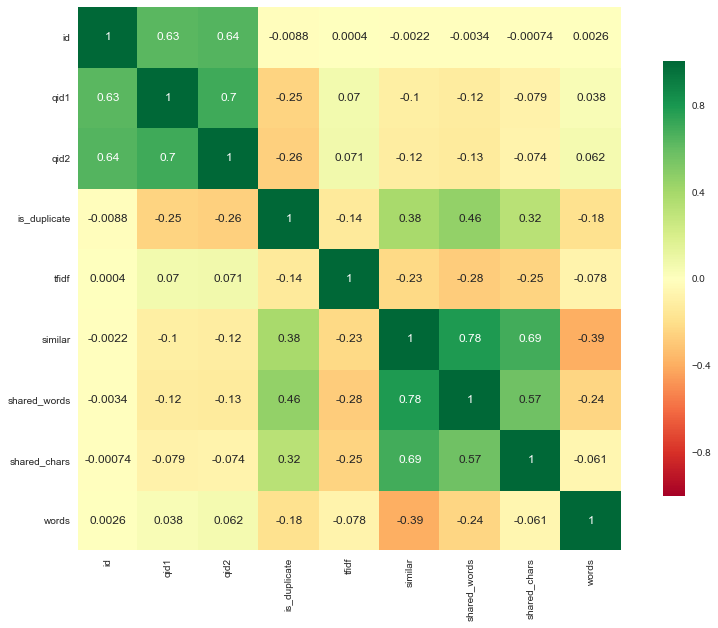

In [96]:
train_data.describe()
g.plot_correlation_map(train_data)

# Feature selection

In [27]:
labels = ['0', '1']

y = train_data.is_duplicate
# print(y.value_counts())
Y = p.onehot(y)

Y: (404290, 2) 


In [100]:
importlib.reload(p)

pf1 = s.percentile_filter(x_q1, y, percentile=50)
pf2 = s.percentile_filter(x_q2, y, percentile=50)

x0 = train_data[['shared_words', 'shared_chars', 'similar']]
x1 = s.select(x_q1, pf1, question_features)
x2 = s.select(x_q2, pf2, question_features)
x3, scaler = p.scale(train_data[['qid1', 'qid2', 'words']])

x = pd.DataFrame(index=train_data.index)
x = pd.merge(x, x0, left_index=True, right_index=True)
x = pd.merge(x, x1, left_index=True, right_index=True)
x = pd.merge(x, x2, left_index=True, right_index=True)
x = pd.merge(x, x3, left_index=True, right_index=True)

X = x.values
u.log('X train', X.shape)


# x0_test = test_data[['shared_words', 'words1', 'words2', 'similar']]
# x1_test = s.select(x_q1_test, pf1, question_features)
# x2_test = s.select(x_q2_test, pf2, question_features)
# x3_test, scaler = p.scale(test_data[['qid1', 'qid2']])

# x_test = pd.DataFrame(index=test_data.index)
# x_test = pd.merge(x_test, x0_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x1_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x2_test, left_index=True, right_index=True)
# x_test = pd.merge(x_test, x3_test, left_index=True, right_index=True)

# X_test = x_test.values
# u.log('X test', X_test.shape)

S: (404290, 250) 
S: (404290, 250) 
X: (404290, 3) 
X train: (404290, 506) 


In [101]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

u.log('X train', X_train.shape)
u.log('y train', y_train.shape)
Y_train = p.onehot(y_train, title='Y train')

u.log('X val', X_val.shape)
u.log('y val', y_val.shape)
Y_val = p.onehot(y_val, title='Y val')

X train: (270874, 506) 
y train: (270874,) 
Y train: (270874, 2) 
X val: (133416, 506) 
y val: (133416,) 
Y val: (133416, 2) 


# Model

## Keras

In [103]:
importlib.reload(m)
from keras import optimizers as o
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

model = m.keras_single_classification(X.shape[1])
model.compile(loss='binary_crossentropy', optimizer=o.RMSprop(lr=1e-4), metrics=['accuracy'], class_weight=cw)
history = model.fit(X_train, y_train, epochs=15, batch_size=10000)

result = model.evaluate(X_val, y_val, verbose=1)
print('')
u.log(model.metrics_names, result)

# plt.figure(figsize=(12,8))
# g.plot_accuracy(history)
# g.plot_loss(history)

/Users/syk/Work/kaggle/ENV/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/15
270874/270874 [==============================] - 8s - loss: 0.6072 - acc: 0.6973      

## Scikit

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

# clf = RandomForestClassifier(loss='log', class_weight='balanced', n_iter=100, verbose=0)
# clf = GradientBoostingClassifier(n_estimators=10, random_state=6, verbose=1)
# clf = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, verbose=1)
# clf = KNeighborsClassifier()
# clf = SGDClassifier(verbose=1)
# clf = MultinomialNB()

clf.fit(X_train, y_train)
u.log('Score', clf.score(X_val, y_val))

# Cross validation

/Users/syk/Work/kaggle/ENV/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2094: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Logloss: 0.467410275567 
R:              precision    recall  f1-score   support

          0       0.78      0.86      0.82     84128
          1       0.71      0.59      0.65     49288

avg / total       0.76      0.76      0.75    133416
 
Confusion matrix, without normalization
[[72143 11985]
 [20023 29265]]


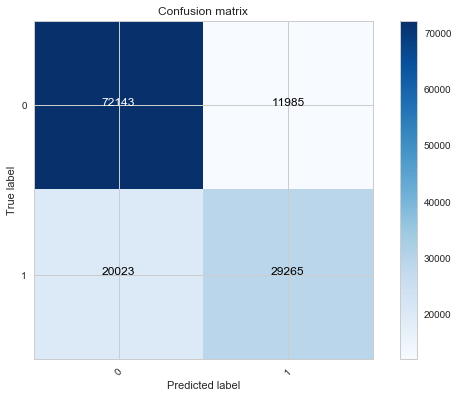

In [104]:
# y_val_prob = clf.predict_proba(X_val)
y_val_prob = model.predict(X_val)
y_val_pred = (y_val_prob > 0.5).astype('int32')

u.log('Logloss', log_loss(y_val, y_val_prob))
u.log('R', classification_report(y_val, y_val_pred, target_names=labels))

cm = confusion_matrix(y_val, y_val_pred)
g.plot_confusion_matrix(cm, labels)

# Prediction

In [1]:
from keras.models import load_model

keras = model
# keras = load_model('keras.h5')
print(keras.summary())

# YY = clf.predict_proba(X_test)
YY = keras.predict(X_test)

print(YY.shape)
print(YY[:10])

Using TensorFlow backend.


NameError: name 'model' is not defined

# Submission

In [ ]:
import time

sample = pd.read_csv('input/sample_submission.csv')
print(sample.shape)

submission = pd.DataFrame(columns=['test_id', 'is_duplicate'])
submission.test_id = sample.test_id
submission.is_duplicate = YY[:, 1]
submission.info()

filename = 'submission-' + time.strftime("%Y%m%d%H%M", time.gmtime()) + '.csv'
submission.to_csv(filename, index=False)

# References

* https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
* https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots
* https://www.kaggle.com/jturkewitz/magic-features-0-03-gain